<a href="https://colab.research.google.com/github/angelamunozc/Talento-tech/blob/main/entrenamiento/CSI_de_los_Datos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🕵️ CSI de los Datos: Detectives del Fraude (Pandas + IA)
**Bootcamp:** IA Innovador — Laboratorio guiado (3 h)  
**By:** Ing. Engler González

**Objetivo:** Investigar patrones sospechosos en transacciones usando **pandas** y (opcionalmente) **Gemini** para redactar una narrativa ejecutiva.

> **Nota:** El lab funciona 100% con *pandas* aunque no configures la IA.  
> Para usar IA, crea la variable de entorno `GOOGLE_API_KEY` en Colab: *Entorno de ejecución → Configurar variables de entorno → Añadir*.


## 0) Setup

In [28]:
!pip -q install pandas numpy matplotlib google-generativeai

import os, math, random, json, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import google.generativeai as genai
from IPython.display import display

np.random.seed(7); pd.set_option("display.max_colwidth", 120)
# Retrieve the API key from Colab secrets
try:
    from google.colab import userdata
    api_key = userdata.get("GOOGLE_API_KEY")
except ImportError:
    # Fallback for environments where userdata is not available
    api_key = os.environ.get("GOOGLE_API_KEY")

model = None
# (Opcional IA) Configura tu GOOGLE_API_KEY en Entorno de ejecución > Variables de entorno
if api_key:
    genai.configure(api_key=api_key)
    model = genai.GenerativeModel("gemini-1.5-flash")
    print("✅ Gemini model configured.")
else:
    print("❌ GOOGLE_API_KEY not found. Gemini model not configured.")

✅ Gemini model configured.


## 1) Generar dataset sintético
No necesitas archivos. Simularemos **60 días** de transacciones en múltiples países y canales. Inyectaremos anomalías a propósito (madrugada, montos altos, duplicados, valores faltantes).


In [29]:
# Escenario: transacciones de 60 días. Inyectamos anomalías.
n = 6000
countries = ["CO", "MX", "US", "AR", "CL", "ES"]
channels = ["web", "app", "social_ads", "affiliate", "email"]   #SON EN DONDE SE HACEN LAS TRANSACCIONES

# Distribución de horas por tramos (más peso en el día). Normalizamos para que sume 1.
hour_weights = [0.02]*6 + [0.04]*6 + [0.06]*6 + [0.02]*6  # 0-5, 6-11, 12-17, 18-23
hour_weights = np.array(hour_weights, dtype=float)
hour_weights = hour_weights / hour_weights.sum()

hours = np.random.choice(range(0,24), size=n, p=hour_weights)
base_amount = np.random.lognormal(mean=3.3, sigma=0.5, size=n) * 10  # distribución sesgada
country = np.random.choice(countries, size=n, p=[0.32,0.20,0.16,0.12,0.12,0.08])
channel = np.random.choice(channels, size=n, p=[0.35,0.25,0.15,0.15,0.10])
user_id = np.random.randint(1000, 5000, size=n)
days = pd.date_range(end=pd.Timestamp.today().normalize(), periods=60)
timestamp = np.random.choice(days, size=n) + pd.to_timedelta(hours, unit="h")

# Inyectar patrones sospechosos
amount = base_amount.copy()
mask_night = (hours < 6) | (hours > 22)
amount[mask_night] *= np.random.uniform(1.4, 2.1, size=mask_night.sum())  # montos más altos de madrugada

mask_remote = np.isin(country, ["ES","US"]) & np.isin(channel, ["affiliate","social_ads"])
amount[mask_remote] *= np.random.uniform(1.2, 1.8, size=mask_remote.sum())

# Outliers y duplicados
idx_out = np.random.choice(range(n), size=40, replace=False)
amount[idx_out] *= np.random.uniform(3, 10, size=40)
duplicated_rows = 30
dups = np.random.choice(range(n), size=duplicated_rows, replace=False)

df = pd.DataFrame({
    "transaction_id": [f"T{100000+i}" for i in range(n)],
    "user_id": user_id,
    "amount": amount.round(2),
    "country": country,
    "channel": channel,
    "timestamp": timestamp
})
df = pd.concat([df, df.iloc[dups]], ignore_index=True)  # añadir duplicados

# Nulos/errores de formato
df.loc[np.random.choice(df.index, 50, replace=False), "channel"] = None
df.loc[np.random.choice(df.index, 30, replace=False), "country"] = "??"
df.loc[np.random.choice(df.index, 20, replace=False), "amount"] = None

print("✅ Dataset generado:", df.shape)
df.head()

✅ Dataset generado: (6030, 6)


,transaction_id,user_id,amount,country,channel,timestamp
0,T100000,4140,511.60,CO,web,2025-07-16 03:00:00
1,T100001,4078,171.44,CO,app,2025-08-13 16:00:00
2,T100002,1095,241.59,CL,email,2025-07-25 12:00:00
3,T100003,2871,216.57,CO,app,2025-07-07 16:00:00
4,T100004,2232,504.38,CO,affiliate,2025-08-23 23:00:00


## 2) Limpieza de datos (GUIADA)
**TODOs**  
1. Revisar info general, nulos y duplicados.  
2. Eliminar duplicados exactos.  
3. Asegurar tipos correctos (`timestamp` → datetime, `amount` → float).  
4. Normalizar categorías (reemplazar `"??"` por `NaN`, decidir imputación/filtrado).  
5. Tratar nulos en `amount` y `channel` (documentar la decisión).


In [30]:
# --- Punto de partida y pistas ---
df.info()
print("\nNulos antes:", df.isna().sum())
df.isna().mean().sort_values(ascending=False).head(10)

dup_before = df.duplicated().sum() # Define dup_before before using it
print("\nDuplicados antes:", dup_before)
df = df.drop_duplicates()
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df["amount"] = pd.to_numeric(df["amount"], errors="coerce")
df["country"] = df["country"].replace("??", np.nan)

drop_amount_before = int (df["amount"].isna().sum()) # Define drop_amount_before
df = df.dropna(subset=["amount"])

# Correct the variable name and calculate the rate after dropping rows with null amount
channel_null_rate_initial = float(df["channel"].isna().mean())
if channel_null_rate_initial <= 0.05:
  df ["channel"] = df ["channel"].fillna ("unknown")

clean_report = { "duplicados_eliminados": int (dup_before), # Calculate eliminated duplicates
                  "amount_nulos_eliminados": drop_amount_before, # Calculate eliminated amount nulls
                   "null_channel_rate_inicial" : channel_null_rate_initial # Use the corrected variable name
  }
display(clean_report) # Use display for better output formatting

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6030 entries, 0 to 6029
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  6030 non-null   object        
 1   user_id         6030 non-null   int64         
 2   amount          6010 non-null   float64       
 3   country         6030 non-null   object        
 4   channel         5980 non-null   object        
 5   timestamp       6030 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 282.8+ KB

Nulos antes: transaction_id     0
user_id            0
amount            20
country            0
channel           50
timestamp          0
dtype: int64

Duplicados antes: 29


{'duplicados_eliminados': 29,
 'amount_nulos_eliminados': 20,
 'null_channel_rate_inicial': 0.008359806052499582}

In [4]:

df.info()
print("\nNulos antes:", df.isna().sum())
df.isna().mean().sort_values(ascending=False).head(10)

dup_before = df.duplicated().sum() # Define dup_before before using it SUMA TODOS LOS DUPLICADOS
df = df.drop_duplicates()
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df["amount"] = pd.to_numeric(df["amount"], errors="coerce")
df["country"] = df["country"].replace("??", np.nan)

drop_amount = int (df["amount"].isna().sum()) # Define drop_amount_before
df = df.dropna(subset=["amount"])

null_channel_rate_initial = float(df["channel"].isna().mean())
if null_channel_rate_initial <= 0.05:
  df ["channel"] = df ["channel"].fillna ("unknown")    # SE PONE DESCONOCIDO EM LUYAFR DE NULO

clean_report = { "duplicados_eliminados": int (dup_before), # Calculate eliminated duplicates
                  "amount_nulos_eliminados": drop_amount, # Calculate eliminated amount nulls
                   "null_channel_rate_inicial" : null_channel_rate_initial # Use the corrected variable name
  }
clean_report # Use display for better output formatting

<class 'pandas.core.frame.DataFrame'>
Index: 5981 entries, 0 to 6017
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  5981 non-null   object        
 1   user_id         5981 non-null   int64         
 2   amount          5981 non-null   float64       
 3   country         5951 non-null   object        
 4   channel         5981 non-null   object        
 5   timestamp       5981 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 327.1+ KB

Nulos antes: transaction_id     0
user_id            0
amount             0
country           30
channel            0
timestamp          0
dtype: int64


{'duplicados_eliminados': 0,
 'amount_nulos_eliminados': 0,
 'null_channel_rate_inicial': 0.0}

## 3) EDA: entender el comportamiento
**TODOs**  
6. Crear columnas derivadas: `hour`, `day_of_week`.  
7. Resúmenes clave:  
   - monto promedio por país  
   - distribución por canal  
   - actividad por hora  
   - top usuarios por monto total (opcional)


Monto promedio por país:


,amount
country,
US,428.713793
ES,419.389016
CL,360.198683
CO,355.124701
MX,349.753926
AR,344.226925



Distribución por canal:


,count
channel,
web,2139
app,1410
social_ads,893
affiliate,879
email,610
unknown,50



Actividad por hora:


,transaction_id
hour,
0,135
1,132
2,150
3,154
4,139
5,138
6,308
7,290
8,298


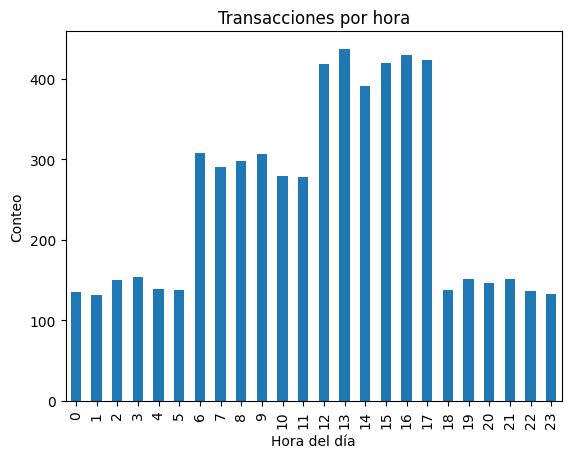

In [31]:
df["hour"] = df["timestamp"].dt.hour
df["day_of_week"] = df["timestamp"].dt.day_name()

mean_by_country = df.groupby("country", dropna=True)["amount"].mean().sort_values(ascending=False)
count_by_channel = df["channel"].value_counts(dropna=False)
activity_by_hour = df.groupby("hour")["transaction_id"].count()

print("Monto promedio por país:"); display(mean_by_country.head(10))
print("\nDistribución por canal:"); display(count_by_channel)
print("\nActividad por hora:"); display(activity_by_hour.head(24))

# Gráfico simple (matplotlib)
plt.figure()
activity_by_hour.plot(kind="bar")
plt.title("Transacciones por hora")
plt.xlabel("Hora del día")
plt.ylabel("Conteo")
plt.show()

## 4) Detección de outliers y reglas de sospecha
**TODOs**  
8. Detectar outliers por IQR en `amount`.  
9. Crear reglas heurísticas (ajusta umbrales con tu EDA):  
   - madrugada (`hour` < 6 o > 22) con `amount` > p95  
   - `affiliate`/`social_ads` con `amount` > p95  
   - `country` o `channel` nulos con `amount` > p95  
10. Construir un **score de sospecha** sumando reglas (0–3/4).


In [32]:
#CALCULAR ESTADISTICOS DE DISPERSION Y PERCENTILES

q1, q3 = df["amount"].quantile([0.25, 0.75])
iqr = q3 - q1
lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr

#OUTLIERS CLASICOS IQR (BULIAN O BANDERAS)
df["is_outlier_amount"] = (df["amount"] < lower) | (df["amount"] > upper)

p95 = df["amount"].quantile(0.95)
df["is_night"] = (df["hour"] < 6) | (df["hour"] > 22)
df["rule_night_high"] = df["is_night"] & (df["amount"] > p95)
df["rule_affiliate_high"] = df["channel"].isin(["affiliate","social_ads"]) & (df["amount"] > p95)
df["rule_missing_high"] = (df["country"].isna() | df["channel"].isna()) & (df["amount"] > p95)

rule_cols = ["is_outlier_amount","rule_night_high","rule_affiliate_high","rule_missing_high"]
df["suspicion_score"] = df[rule_cols].sum(axis=1)

df[["amount","hour","country","channel","is_outlier_amount","rule_night_high","rule_affiliate_high","rule_missing_high","suspicion_score"]].head(10)

p99 = df["amount"].quantile(0.99)
p90 = df["amount"].quantile(0.90)



## 5) Ranking de casos y explicación
**TODOs**  
11. Ordena por `suspicion_score` y revisa el **Top 20**. Escribe 3 observaciones.


In [33]:
top_cases = df.sort_values(["suspicion_score","amount"], ascending=[False, False]).head(20)
top_cases[["transaction_id","user_id","amount","country","channel","hour","suspicion_score"]]

,transaction_id,user_id,amount,country,channel,hour,suspicion_score
504,T100504,2332,3421.63,US,affiliate,0,3
5013,T105013,4560,2957.98,US,social_ads,3,3
1587,T101587,1179,2506.48,MX,affiliate,3,3
832,T100832,2218,2472.13,CO,social_ads,0,3
413,T100413,1008,2132.67,US,affiliate,23,3
1473,T101473,3129,2131.12,US,social_ads,5,3
4381,T104381,3209,1983.10,CO,social_ads,4,3
5343,T105343,4885,1805.96,ES,social_ads,1,3
304,T100304,2043,1733.04,ES,social_ads,2,3
5005,T105005,3008,1647.44,CO,social_ads,0,3


## 6) (Opcional) IA para narrativa ejecutiva
Si tienes `GOOGLE_API_KEY`, genera un *brief* de 6 líneas para directivos con patrones, acciones y métricas.


In [34]:
if model:
    resumen_stats = {
        "p95_amount": float(p95),
        "outlier_rate": float(df["is_outlier_amount"].mean()),
        "night_rate": float(df["is_night"].mean()),
        "top_channels": df["channel"].value_counts().head(3).to_dict()
    }
    prompt = f"""
    Eres analista forense de datos. Con base en:
    Stats: {json.dumps(resumen_stats)}
    Reglas aplicadas: {rule_cols}
    Redacta un briefing ejecutivo (6 líneas) explicando:
    - Qué patrones sugieren posible fraude
    - Acciones inmediatas (reglas de negocio, límites, monitoreo)
    - Métricas a vigilar la próxima semana
    """
    print(model.generate_content(prompt).text)
else:
    print("⚠️ IA no configurada. El análisis se puede entregar igual con pandas y gráficos.")

El análisis de datos revela un 5% de transacciones sospechosas como outliers (p95_amount: $793.86),  con alta incidencia nocturna (16%).  El canal web presenta el mayor volumen de transacciones (2139).  Se sugiere revisar urgentemente las reglas 'is_outlier_amount', 'rule_night_high', y ajustar límites en montos y horarios.  Monitorear  `outlier_rate` y `night_rate` la próxima semana,  prestando atención al comportamiento de cada canal.  Investigar las reglas 'rule_affiliate_high' y 'rule_missing_high'.



## 7) Reto final (entrega)
12. Ajusta y compara umbrales (`p90`/`p95`/`p99`).  
13. Añade más países y **1 regla nueva** por país-hora.  
14. Genera **2 gráficos** que respalden tus reglas (ej: día vs noche, por canal).  
15. Redacta **5 conclusiones numeradas**.


In [6]:
print("🧩 Reto final: ajusta umbrales, agrega 1 regla nueva, 2 gráficos y 5 conclusiones.")

🧩 Reto final: ajusta umbrales, agrega 1 regla nueva, 2 gráficos y 5 conclusiones.


In [35]:
p90 = df["amount"]. quantile(0.90)
p95 = df["amount"]. quantile(0.95)
p99 = df["amount"]. quantile(0.99)

#df['is_outlier_amount'] = (df['amount'] < lower) | (df['amount'] > upper)

df ["amount_over_p90"] = df ["amount"] > p90
df ["amount_over_p95"] = df ["amount"] > p95
df ["amount_over_p99"] = df ["amount"] > p99

percent_over_p90 = (df ["amount_over_p90"].mean()) * 100
percent_over_p95 = (df ["amount_over_p95"].mean()) * 100
percent_over_p99 = (df ["amount_over_p99"].mean()) * 100

print (f"Porcentaje de transaccion por encima del 90%: {percent_over_p90:.2f}%")
print (f"Porcentaje de transaccion por encima del 95%: {percent_over_p95:.2f}% ")
print (f"Porcentaje de transaccion por encima del 99%: {percent_over_p99:.2f}%")




Porcentaje de transaccion por encima del 90%: 10.00%
Porcentaje de transaccion por encima del 95%: 5.00% 
Porcentaje de transaccion por encima del 99%: 1.00%


In [40]:
p90 = df["amount"].quantile(0.90)
df["rule_country_hour"] = (df["country"] == "CL") & (df["hour"].between(0,5)) & (df["amount"] > p90)  #siempre poner punto en la hora para tener un rango

rule_cols_v3 = ["is_outlier_amount","rule_night_high","rule_affiliate_high","rule_missing_high","rule_country_hour"]
df["suspicion_score_v3"] = df[rule_cols_v3].sum(axis=1)

top_cases_v3 = df.sort_values(["suspicion_score_v3","amount"], ascending=[False, False]).head(10)
display(top_cases_v3[["transaction_id","user_id","amount","country","channel","hour","suspicion_score_v3"]])

,transaction_id,user_id,amount,country,channel,hour,suspicion_score_v3
2924,T102924,4308,1346.53,CL,affiliate,5,4
475,T100475,2088,912.91,CL,social_ads,3,4
1400,T101400,4388,907.46,CL,affiliate,2,4
2770,T102770,2517,899.39,CL,affiliate,3,4
5427,T105427,4997,828.68,CL,social_ads,3,4
504,T100504,2332,3421.63,US,affiliate,0,3
5013,T105013,4560,2957.98,US,social_ads,3,3
1587,T101587,1179,2506.48,MX,affiliate,3,3
832,T100832,2218,2472.13,CO,social_ads,0,3
413,T100413,1008,2132.67,US,affiliate,23,3


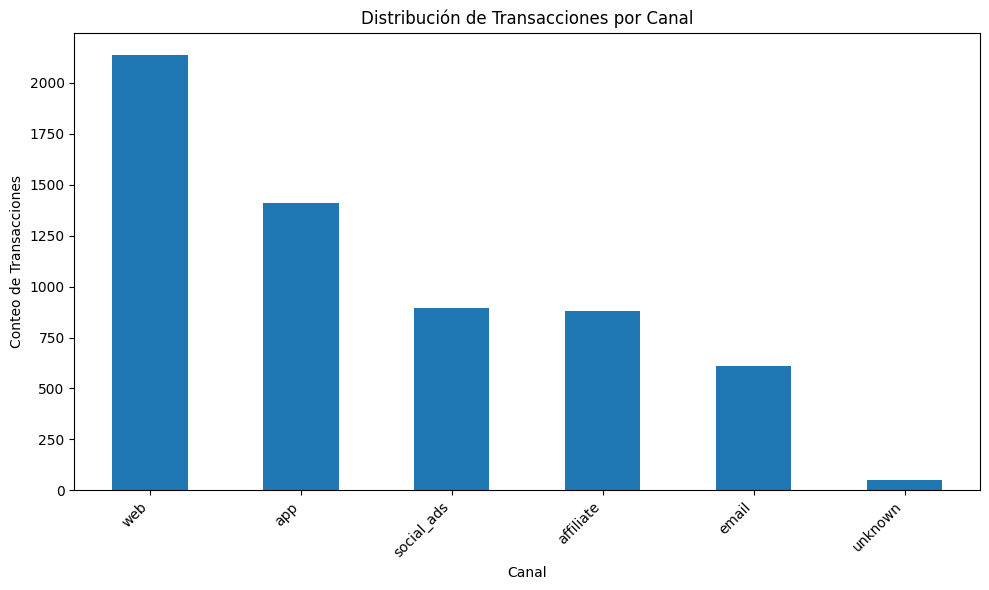

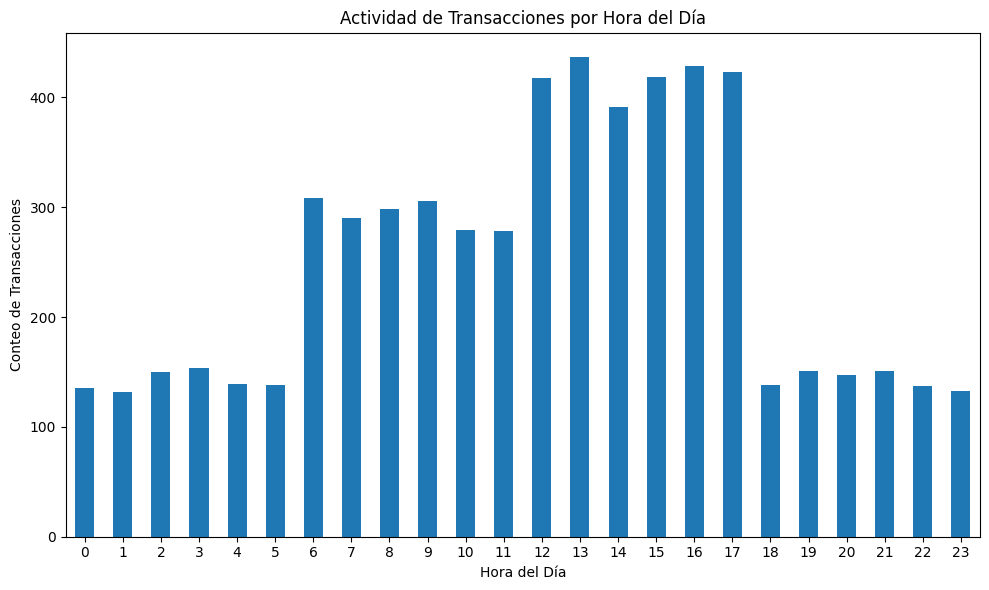

In [41]:
# Gráfico de distribución por canal
plt.figure(figsize=(10, 6))
df["channel"].value_counts(dropna=False).plot(kind="bar")
plt.title("Distribución de Transacciones por Canal")
plt.xlabel("Canal")
plt.ylabel("Conteo de Transacciones")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Gráfico de actividad por hora (Día vs Noche)
plt.figure(figsize=(10, 6))
df["hour"].value_counts().sort_index().plot(kind="bar")
plt.title("Actividad de Transacciones por Hora del Día")
plt.xlabel("Hora del Día")
plt.ylabel("Conteo de Transacciones")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [43]:
transactions_by_country = df["country"].value_counts(dropna=False)
print("Número de transacciones por país:")
display(transactions_by_country)

Número de transacciones por país:


,count
country,
CO,1904
MX,1192
US,957
CL,729
AR,722
ES,447
NaN,30


In [46]:
print("Mis 5 conclusiones sobre el análisis de transacciones:")
print("1. El mayor número de transacciones se realizan por la WEB.")
print("2. Las transacciones se realizan por email como penúltima opción.")
print("3. A la una de la tarde se presenta el mayor número de transacciones por día.")
print("4. Entre las 18 y 5 horas se generan entre 100 y 200 transacciones por día.")
print("5. El país que realiza mayor cantidad de transacciones es CO.")

Mis 5 conclusiones sobre el análisis de transacciones:
1. El mayor número de transacciones se realizan por la WEB.
2. Las transacciones se realizan por email como penúltima opción.
3. A la una de la tarde se presenta el mayor número de transacciones por día.
4. Entre las 18 y 5 horas se generan entre 100 y 200 transacciones por día.
5. El país que realiza mayor cantidad de transacciones es CO.
